In [114]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import sys
import json
import torch
import re
import os
import h5py
import lightning.pytorch as pl
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
warnings.filterwarnings('ignore')
np.random.seed(42)


In [115]:
from helper_fn_short_val import *


In [116]:
import yaml
config = yaml.safe_load(open("train.yaml"))

## Read data

In [117]:
class_encode_path = config['class_encode_path']
truncated_label_path = config['truncated_label_path']
truncated_embed_path = config['truncated_embed_path']

In [118]:
val_tool = Validation_tool(class_encode_path) # provide your own class_encode.json

In [119]:
N_METALS = len(val_tool.class_encode)

In [122]:
labels = os.listdir(truncated_label_path)
LABEL_TEST_INX = [i for i in range(len(labels)) if 'test' in labels[i]][0]
test_label_name = labels[LABEL_TEST_INX]
del labels[LABEL_TEST_INX]
LABEL_POS_INX = [i for i in range(len(labels)) if 'pos' in labels[i]][0]

In [124]:
val_tool.dataset_class_summary(f'{truncated_label_path}{labels[LABEL_POS_INX]}')


Zn(2+)                   |3399
Mg(2+)                   |1350
[4Fe-4S] cluster         |537
Ca(2+)                   |2758
Mn(2+)                   |679
a divalent metal cation  |8648
Fe cation                |686
[2Fe-2S] cluster         |227
Cu cation                |415
K(+)                     |97
Ni(2+)                   |47
Na(+)                    |79
Fe(3+)                   |82
iron-sulfur cluster      |791
Cu(2+)                   |16
Fe(2+)                   |15
Co(2+)                   |32
a metal cation           |9850
neg                      |1056314


### Read embedding files

In [129]:
embeds = os.listdir(truncated_embed_path)
EMBED_TEST_INX = [i for i in range(len(embeds)) if 'test' in embeds[i]][0]
test_embeds_name = embeds[EMBED_TEST_INX]
del embeds[EMBED_TEST_INX] 
EMBED_POS_INX = [i for i in range(len(embeds)) if 'pos' in embeds[i]][0]

In [131]:
h5files = [h5py.File(f"{truncated_embed_path}{embeds[i]}", 'r') for i in range(len(embeds))]

In [132]:
f_test = h5py.File(f"{truncated_embed_path}{test_embeds_name}", 'r')


### Train Validation Split

In [134]:
five_fold_splits = [val_tool.five_fold_val_split(f"{truncated_label_path}{labels[i]}") for i in range(len(labels))]


not enough data to divide ['CHEBI:29033', 'Fe(2+)'], add to all split!


In [135]:
for i in range(5):
    print(f"fold {i+1}")
    for split in five_fold_splits:
        print(f"{len(split[f'fold{i}']['train'])} {len(split[f'fold{i}']['test'])}")
    print()

fold 1
2475 619
2507 627
2493 624
2504 627
2467 617
2474 619
2487 622
2442 611
2533 634
2412 603
2451 613
2550 638
2388 598
2492 623
2436 609
2440 611
2464 625

fold 2
2475 619
2507 627
2493 624
2505 626
2467 617
2474 619
2487 622
2442 611
2533 634
2412 603
2451 613
2550 638
2389 597
2492 623
2436 609
2441 610
2467 622

fold 3
2475 619
2507 627
2494 623
2505 626
2467 617
2474 619
2487 622
2442 611
2534 633
2412 603
2451 613
2550 638
2389 597
2492 623
2436 609
2441 610
2469 620

fold 4
2475 619
2507 627
2494 623
2505 626
2467 617
2475 618
2487 622
2443 610
2534 633
2412 603
2451 613
2551 637
2389 597
2492 623
2436 609
2441 610
2473 616

fold 5
2476 618
2508 626
2494 623
2505 626
2468 616
2475 618
2488 621
2443 610
2534 633
2412 603
2452 612
2551 637
2389 597
2492 623
2436 609
2441 610
2477 612



## Acc ls generate

In [136]:
train_pos = five_fold_splits[LABEL_POS_INX]['fold0']['train'].copy()
train_neg = [five_fold_splits[i]['fold0']['train'].copy() for i in range(len(five_fold_splits)) if i != LABEL_POS_INX]


In [137]:
valid_acc = five_fold_splits[LABEL_POS_INX]['fold0']['test'].copy()

for i in range(len(labels)-1):
    if i != LABEL_POS_INX:
        valid_acc.extend(five_fold_splits[i]['fold0']['test'])
len(valid_acc)


10520

In [138]:
test_acc_ls = list(f_test.keys())

In [139]:
len(test_acc_ls)

5822

## Read labels files

In [140]:
label_files = [np.load(f"{truncated_label_path}{labels[i]}") for i in range(len(labels))]
label = {}
for f in label_files:
    for k, v in f.items():
        label[k] = v

In [141]:
label_valid = {key: value for key, value in (label).items() if key in valid_acc}
len(label_valid)

10520

In [142]:
label_test = np.load(f"{truncated_label_path}{test_label_name}")
label_test = {key: value for key, value in label_test.items()}

In [143]:
len(label_test)

5822

## TFE model

In [241]:
class MyStreamDataset_over_sample_TFE:

    def __init__(self, pos_acc, neg_acc_ls, labels, pos, neg=None, precision=np.float16):
        self.pos_f = pos  # h5 file
        self.labels = labels  # labels for both pos and neg
        self.index = np.random.randint(0, len(neg_acc_ls))
        print(f"neg index: {self.index}")
        self.neg_f = neg[self.index]
        self.acc_ls = pos_acc + neg_acc_ls[self.index]
        self.pos_acc = list(self.pos_f.keys())
        self.labels = labels  # labels for both pos and neg
        self.dim = self.pos_f[list(self.pos_f.keys())[0]][()].shape[1]
        self.precision = precision

    def __len__(self):
        return len(self.acc_ls)

    def __getitem__(self, idx):
        acc = self.acc_ls[idx]
        if acc in self.pos_acc:
            embedding = self.pos_f[acc][()]
        else:
            embedding = self.neg_f[acc][()]

        label = self.labels[acc]

        prot_len = embedding.shape[0]

        if label.shape == (1,):
            label = np.zeros((N_METALS, prot_len), dtype=self.precision)

        if self.precision == np.float16:
            torch_type = torch.float16
        else:
            torch_type = torch.float32
        return embedding, torch.tensor(label, dtype=torch_type)

    def padding(self, batch, maxlen):
        batch_protein_feat = []
        batch_protein_mask = []
        for protein_feat in batch:
            padded_protein_feat = np.zeros((maxlen, self.dim))
            padded_protein_feat[:protein_feat.shape[0]] = protein_feat
            padded_protein_feat = torch.tensor(
                padded_protein_feat, dtype=torch.float)
            batch_protein_feat.append(padded_protein_feat)

            protein_mask = np.zeros(maxlen)
            protein_mask[:protein_feat.shape[0]] = 1
            protein_mask = torch.tensor(protein_mask, dtype=torch.long)
            batch_protein_mask.append(protein_mask)

        return torch.stack(batch_protein_feat), torch.stack(batch_protein_mask)

    def collate_fn(self, batch):
        features, labels = zip(*batch)
        max_batch_len = max([x.shape[0] for x in features])
        features, masks = self.padding(features, max_batch_len)
        return features, torch.hstack(labels), masks


In [242]:
class MyStreamDataset_TFE:
    def __init__(self, acc_ls, labels, files, precision=np.float16):
        self.files = files  # h5 file
        self.acc_ls = acc_ls
        self.labels = labels  # labels for both pos and neg
        f0 = self.files[0]
        self.dim = f0[list(f0.keys())[0]][()].shape[1]
        self.precision = precision
        self.dc_ls = {i: files[i].keys() for i in range(len(files))}


    def __len__(self):
        return len(self.acc_ls)

    def __getitem__(self, idx):
        acc = self.acc_ls[idx]
        for i, f in self.dc_ls.items():
            if acc in f:
                embedding = self.files[i][acc][()]
                break
        label = self.labels[acc]

        prot_len = embedding.shape[0]

        if label.shape == (1,):
            label = np.zeros((N_METALS, prot_len), dtype=self.precision)

        if self.precision == np.float16:
            torch_type = torch.float16
        else:
            torch_type = torch.float32
        return embedding, torch.tensor(label, dtype=torch_type)

    def padding(self, batch, maxlen):
        batch_protein_feat = []
        batch_protein_mask = []
        for protein_feat in batch:
            padded_protein_feat = np.zeros((maxlen, self.dim))
            padded_protein_feat[:protein_feat.shape[0]] = protein_feat
            padded_protein_feat = torch.tensor(
                padded_protein_feat, dtype=torch.float)
            batch_protein_feat.append(padded_protein_feat)

            protein_mask = np.zeros(maxlen)
            protein_mask[:protein_feat.shape[0]] = 1
            protein_mask = torch.tensor(protein_mask, dtype=torch.long)
            batch_protein_mask.append(protein_mask)

        return torch.stack(batch_protein_feat), torch.stack(batch_protein_mask)

    def collate_fn(self, batch):
        features, labels = zip(*batch)
        max_batch_len = max([x.shape[0] for x in features])
        features, masks = self.padding(features, max_batch_len)
        return features, torch.hstack(labels), masks


### Label weights generate

In [21]:
# acc_len_dc = {}
# for f in [f_pos, f_neg0, f_neg1, f_neg2, f_neg3, f_neg4, f_neg5, f_neg6, f_neg7, f_neg8, f_neg9, f_neg10, f_neg11, f_neg12, f_neg13, f_neg14, f_neg15]:
#     for acc in f.keys():
#         acc_len_dc[acc] = f[acc][()].shape[0]

In [22]:
# pos_num = 0
# neg_num = 0
# for key, value in (label).items():
#     if value.shape == (1,):
#         neg_num += acc_len_dc[key]
#         continue
#     pos = np.sum(value, axis=1)
#     neg = acc_len_dc[key] - pos
#     pos = np.mean(pos)
#     neg = np.mean(neg)
#     pos_num += pos
#     neg_num += neg
    
    
# neg_num, pos_num


In [23]:
# np.around(1000/np.sqrt(neg_num),5), np.around(1000/np.sqrt(pos_num),5)
# (0.24028, 24.61498)


In [24]:
# np.around(100/np.power(neg_num, 1/3),5), np.around(100/np.power(pos_num, 1/3),5)
# (0.3865, 8.46187)


In [25]:
# pos_num = 0
# neg_num = 0
# for i in [l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12, l13, l14, l15, l16, l17]:
#     for key, value in (l1|i).items():
#         if value.shape == (1,):
#             neg_num += acc_len_dc[key]
#             continue
#         pos = np.sum(value, axis=1)
#         neg = acc_len_dc[key] - pos
#         pos = np.mean(pos)
#         neg = np.mean(neg)
#         pos_num += pos
#         neg_num += neg


# neg_num = neg_num/16
# pos_num = pos_num/16
# neg_num, pos_num


In [26]:
# np.around(1000/np.sqrt(neg_num),5), np.around(1000/np.sqrt(pos_num),5)
# (0.69317, 24.61498)


In [27]:
# np.around(100/np.power(neg_num, 1/3),5), np.around(100/np.power(pos_num, 1/3),5)
# (0.78324, 8.46187)


In [248]:


class Self_Attention(nn.Module):
    def __init__(self, num_hidden, num_heads=4, weight_matrix = False):
        super().__init__()
        self.num_heads = num_heads
        self.attention_head_size = int(num_hidden / num_heads)
        self.all_head_size = self.num_heads * self.attention_head_size
        self.wq = nn.Linear(num_hidden, self.all_head_size)
        self.wk = nn.Linear(num_hidden, self.all_head_size)
        self.wv = nn.Linear(num_hidden, self.all_head_size)
        self.wo = nn.Linear(self.all_head_size, num_hidden)
        self.weight_matrix = weight_matrix

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_heads,
                                       self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, q, k, v, mask=None):
        if self.weight_matrix:
            q = self.transpose_for_scores(self.wq(q))
            k = self.transpose_for_scores(self.wk(k))
            v = self.transpose_for_scores(self.wv(v))
        else:
            q = self.transpose_for_scores(q) 
            k = self.transpose_for_scores(k)
            v = self.transpose_for_scores(v)

        attention_scores = torch.matmul(q, k.transpose(-1, -2))

        if mask is not None:
            attention_mask = (1.0 - mask) * -10000
            attention_scores = attention_scores + \
                attention_mask.unsqueeze(1).unsqueeze(1)

        attention_scores = nn.Softmax(dim=-1)(attention_scores)

        outputs = torch.matmul(attention_scores, v)

        outputs = outputs.permute(0, 2, 1, 3).contiguous()
        new_output_shape = outputs.size()[:-2] + (self.all_head_size,)
        outputs = outputs.view(*new_output_shape)
        if self.weight_matrix:
            outputs = self.wo(outputs)
        return outputs

class PositionWiseFeedForward(nn.Module):
    def __init__(self, num_hidden, num_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.W_in = nn.Linear(num_hidden, num_ff, bias=True)
        self.W_out = nn.Linear(num_ff, num_hidden, bias=True)

    def forward(self, h_V):
        h = F.leaky_relu(self.W_in(h_V))
        h = self.W_out(h)
        return h


class TransformerLayer(nn.Module):
    def __init__(self, num_hidden=64, num_heads=4, dropout=0.2):
        super(TransformerLayer, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.ModuleList(
            [nn.LayerNorm(num_hidden, eps=1e-6) for _ in range(2)])

        self.attention = Self_Attention(num_hidden, num_heads)
        self.dense = PositionWiseFeedForward(num_hidden, num_hidden * 4)

    def forward(self, h_V, mask=None):
        # Self-attention
        dh = self.attention(h_V, h_V, h_V, mask)
        h_V = self.norm[0](h_V + self.dropout(dh))

        # Position-wise feedforward
        dh = self.dense(h_V)
        h_V = self.norm[1](h_V + self.dropout(dh))

        if mask is not None:
            mask = mask.unsqueeze(-1)
            h_V = mask * h_V
        return h_V


class MetalBPredictor(nn.Module):
    def __init__(self, feature_dim, hidden_dim=64, num_encoder_layers=2, num_heads=4, dropout=0.2):
        super(MetalBPredictor, self).__init__()

        # Embedding layers
        self.input_block = nn.Sequential(
            nn.LayerNorm(feature_dim, eps=1e-6), nn.Linear(feature_dim,
                                                           hidden_dim), nn.LeakyReLU()
        )

        self.hidden_block = nn.Sequential(
            nn.LayerNorm(hidden_dim, eps=1e-6), nn.Dropout(dropout), nn.Linear(
                hidden_dim, hidden_dim), nn.LeakyReLU(), nn.LayerNorm(hidden_dim, eps=1e-6)
        )

        # Encoder layers
        self.encoder_layers = nn.ModuleList([
            TransformerLayer(hidden_dim, num_heads, dropout)
            for _ in range(num_encoder_layers)
        ])

        # ion-specific layers
        self.dense = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(hidden_dim, N_METALS)
        # Initialization
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, protein_feat, mask):
        h_V = self.input_block(protein_feat)
        h_V = self.hidden_block(h_V)

        for layer in self.encoder_layers:
            h_V = layer(h_V, mask)
            
        x = self.dense(h_V)
        x = self.dropout(x)
        logits = self.out_proj(x)
        logits = torch.flatten(logits, end_dim=1)
        return logits


In [249]:
class TransformerModel(pl.LightningModule):
    def __init__(self, train_pos, train_neg, feature_dim, hidden_dim=64, num_encoder_layers=2, num_heads=4, dropout=0.2, lr=1e-3, label_weight=[0.228, 5.802], batch_size=32, thres_tune=False):
        super().__init__()
        self.encoder = MetalBPredictor(
            feature_dim, hidden_dim, num_encoder_layers, num_heads, dropout)
        self.save_hyperparameters()

        self.val_loss = 0
        self.test_loss = 0
        self.learning_rate = lr
        self.label_weight = label_weight
        self.batch_size = batch_size
        self.train_pos = train_pos
        self.train_neg = train_neg
        self.val_y = []
        self.val_pred = []
        self.test_y = []
        self.test_pred = []
        self.thres_tune = thres_tune

    def forward(self, x, mask):
        x = self.encoder(x, mask)
        return torch.squeeze(x)

    def loss_fn(self, out, target):
        weight = torch.ones_like(target)
        # 0.228, 5.802
        weight[target == 0] = self.label_weight[0]
        weight[target == 1] = self.label_weight[1]

        return torch.nn.BCEWithLogitsLoss(reduction='none', weight=weight)(out, target).mean(axis=0).sum()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.learning_rate, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=64)
        return [optimizer], [lr_scheduler]
        # return optimizer

    def training_step(self, batch, batch_idx):
        x, y, masks = batch
        out = self(x, masks)
        out = out[(torch.flatten(masks) == 1), :]
        loss = self.loss_fn(out, y.T)
        self.log('train_loss', loss)
        return loss

    def train_dataloader(self):
        train_dataset = MyStreamDataset_over_sample_TFE(self.train_pos, self.train_neg, label, h5files[EMBED_POS_INX], [h5files[i] for i in range(len(h5files)) if i != EMBED_POS_INX], precision=np.float32)

        train_dataloader = torch.utils.data.DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)
        return train_dataloader

    def validation_step(self, batch, batch_idx):
        x, y, masks = batch
        out = self(x, masks)
        # print(out.shape)
        out = out[(torch.flatten(masks) == 1), :]
        loss = self.loss_fn(out, y.T)
        self.val_loss += loss
        self.val_y.append(y)
        self.val_pred.append(out.T)

    def on_validation_epoch_start(self):
        #print('Validation epoch start')
        #print('val loss before', self.val_loss)
        self.val_loss = 0
        #print('val loss after', self.val_loss)
        self.val_y = []
        self.val_pred = []

    def on_validation_epoch_end(self):
        y = torch.hstack(self.val_y)
        out = torch.hstack(self.val_pred)
        out = torch.sigmoid(out)
        y_true = y.detach().cpu().numpy()
        y_pred = out.detach().cpu().numpy()
        dc = val_tool.sum_full_metrics(y_true, y_pred, 0.5)
        #print('len(self.val_y)', len(self.val_y))
        self.val_loss = self.val_loss / len(self.val_y)
        loss = self.val_loss
        print(f'Validation loss: {loss}')
        self.log('val_loss', loss)
        self.log('MCC', dc['mean MCC'])
        self.log('AUPR', dc['mean AUPR'])
        # print(y_pred.shape)

        # self.log_dict(dc)

    def test_step(self, batch, batch_idx):
        x, y, masks = batch
        out = self(x, masks)
        out = out[(torch.flatten(masks) == 1), :]
        loss = self.loss_fn(out, y.T)
        self.test_loss += loss
        self.test_y.append(y)
        self.test_pred.append(out.T)

    def on_test_epoch_end(self):
        y = torch.hstack(self.test_y)
        out = torch.hstack(self.test_pred)
        out = torch.sigmoid(out)
        y_true = y.detach().cpu().numpy()
        y_pred = out.detach().cpu().numpy()
        
        if self.thres_tune:
            self.y_true = y_true
            self.y_pred = y_pred
        else:
            dc = val_tool.sum_2metrics(y_true, y_pred, 0.5)
            val_tool.plot_pr_curve(y_true, y_pred)
            self.test_loss = self.test_loss / len(self.test_y)
            self.log('test_loss', self.test_loss)


## CNN model

In [250]:

class MyStreamDataset_over_sample_CNN:

    def __init__(self, pos_acc, neg_acc_ls, labels, pos, neg=None, max_len=512, precision=np.float16):
        self.pos_f = pos  # h5 file
        self.labels = labels  # labels for both pos and neg
        self.index = np.random.randint(0, len(neg_acc_ls))
        print(f"neg index: {self.index}")
        self.neg_f = neg[self.index]
        self.acc_ls = pos_acc + neg_acc_ls[self.index]
        self.pos_acc = list(self.pos_f.keys())
        self.labels = labels  # labels for both pos and neg
        self.dim = self.pos_f[list(self.pos_f.keys())[0]][()].shape[1]
        self.max_len = max_len
        self.precision = precision

    def __len__(self):
        return len(self.acc_ls)

    def __getitem__(self, idx):
        acc = self.acc_ls[idx]
        if acc in self.pos_acc:
            embedding = self.pos_f[acc][()]
        else:
            embedding = self.neg_f[acc][()]

        label = self.labels[acc]

        prot_len = embedding.shape[0]

        if label.shape == (1,):
            label = np.zeros((N_METALS, prot_len), dtype=self.precision)

        if self.precision == np.float16:
            torch_type = torch.float16
        else:
            torch_type = torch.float32

        features = np.zeros((self.dim, self.max_len), dtype=self.precision)
        # set feature maps to embedding values
        features[:, :prot_len] = np.transpose(embedding)
        mask = np.zeros((self.max_len), dtype=bool)
        mask[:prot_len] = True

        return torch.tensor(features, dtype=torch_type), torch.tensor(label, dtype=torch_type), torch.tensor(mask, dtype=torch.bool)

    def collate_fn(self, batch):
        features, labels, masks = zip(*batch)
        return torch.stack(features), torch.hstack(labels), torch.hstack(masks)


In [251]:
class MyStreamDataset_CNN:
    def __init__(self, acc_ls, labels, files, max_len=512, precision=np.float16):
        self.files = files  # h5 file
        self.acc_ls = acc_ls
        self.labels = labels  # labels for both pos and neg
        f0 = self.files[0]
        self.dim = f0[list(f0.keys())[0]][()].shape[1]
        self.max_len = max_len
        self.precision = precision

    def __len__(self):
        return len(self.acc_ls)

    def __getitem__(self, idx):
        acc = self.acc_ls[idx]
        for f in self.files:
            f_acc = list(f.keys())
            if acc in f_acc:
                embedding = f[acc][()]
                break
        label = self.labels[acc]

        prot_len = embedding.shape[0]

        if label.shape == (1,):
            label = np.zeros((N_METALS, prot_len), dtype=self.precision)

        # pad all inputs to the maximum length & add another feature to encode whether the element is a position
        # in the sequence or padded
        features = np.zeros((self.dim, self.max_len), dtype=self.precision)
        # set feature maps to embedding values
        features[:, :prot_len] = np.transpose(embedding)
        mask = np.zeros((self.max_len), dtype=bool)
        mask[:prot_len] = True
        if self.precision == np.float16:
            torch_type = torch.float16
        else:
            torch_type = torch.float32
        return torch.tensor(features, dtype=torch_type), torch.tensor(label, dtype=torch_type), torch.tensor(mask, dtype=torch.bool)

    def collate_fn(self, batch):
        features, labels, masks = zip(*batch)
        return torch.stack(features), torch.hstack(labels), torch.hstack(masks)


In [259]:
class Conv1dModel(pl.LightningModule):
    def __init__(self, train_pos, train_neg, in_channels, hidden_channel, kernel_size, hidden_layer_num, lr=1e-3, label_weight=[0.228, 5.802], batch_size=32, thres_tune=False):
        super().__init__()
        stride = 1
        padding = int((kernel_size - 1) / 2)
        modules = []
        in_channel_ = in_channels
        feature_channel_ = hidden_channel
        for i in range(hidden_layer_num):
            modules.append(torch.nn.Conv1d(in_channels=in_channel_, out_channels=feature_channel_, kernel_size=kernel_size,
                                           stride=stride, padding=padding))
            modules.append(torch.nn.ELU())
            in_channel_ = feature_channel_
            feature_channel_ = feature_channel_//2

        modules.append(torch.nn.Conv1d(in_channels=in_channel_, out_channels=N_METALS,
                                       kernel_size=kernel_size, stride=stride, padding=padding))

        self.conv1 = torch.nn.Sequential(*modules)

        self.save_hyperparameters()

        self.val_loss = 0
        self.test_loss = 0
        self.learning_rate = lr
        self.label_weight = label_weight
        self.batch_size = batch_size
        self.train_pos = train_pos
        self.train_neg = train_neg
        self.val_y = []
        self.val_pred = []
        self.test_y = []
        self.test_pred = []
        self.thres_tune = thres_tune

    def forward(self, x):
        x = self.conv1(x)
        return torch.squeeze(x)

    def loss_fn(self, out, target):
        weight = torch.ones_like(target)
        # 0.228, 5.802
        weight[target == 0] = self.label_weight[0]
        weight[target == 1] = self.label_weight[1]
        return torch.nn.BCEWithLogitsLoss(reduction='none', weight=weight)(out, target).mean(axis=0).sum()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.learning_rate, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=64)
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        x, y, masks = batch
        out = self(x)
        out = torch.hstack([i for i in out])[:, masks].T
        loss = self.loss_fn(out, y.T)
        self.log('train_loss', loss)
        return loss

    def train_dataloader(self):
        train_dataset = MyStreamDataset_over_sample_CNN(self.train_pos, self.train_neg, label, h5files[EMBED_POS_INX], [
                                                    h5files[i] for i in range(len(h5files)) if i != EMBED_POS_INX], precision=np.float32)

        train_dataloader = torch.utils.data.DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)
        return train_dataloader

    def validation_step(self, batch, batch_idx):
        x, y, masks = batch
        out = self(x)
        # print(out.shape)
        out = torch.hstack([i for i in out])[:, masks]
        loss = self.loss_fn(out.T, y.T)
        self.val_loss += loss
        self.val_y.append(y)
        self.val_pred.append(out)

    def on_validation_epoch_start(self):
        # print('Validation start')
        self.val_loss = 0
        self.val_y = []
        self.val_pred = []

    def on_validation_epoch_end(self):
        y = torch.hstack(self.val_y)
        out = torch.hstack(self.val_pred)
        out = torch.sigmoid(out)
        y_true = y.detach().cpu().numpy()
        y_pred = out.detach().cpu().numpy()
        dc = val_tool.sum_full_metrics(y_true, y_pred, 0.5)
        self.val_loss = self.val_loss / len(self.val_y)
        loss = self.val_loss
        print(f'Validation loss: {loss}')
        self.log('val_loss', loss)
        self.log('MCC', dc['mean MCC'])
        self.log('AUPR', dc['mean AUPR'])

    def test_step(self, batch, batch_idx):
        x, y, masks = batch
        out = self(x)
        out = torch.hstack([i for i in out])[:, masks]
        loss = self.loss_fn(out.T, y.T)
        self.test_loss += loss
        self.test_y.append(y)
        self.test_pred.append(out)

    def on_test_epoch_end(self):
        y = torch.hstack(self.test_y)
        out = torch.hstack(self.test_pred)
        out = torch.sigmoid(out)
        y_true = y.detach().cpu().numpy()
        y_pred = out.detach().cpu().numpy()

        if self.thres_tune:
            self.y_true = y_true
            self.y_pred = y_pred
        else:
            dc = val_tool.sum_2metrics(y_true, y_pred, 0.5)
            val_tool.plot_pr_curve(y_true, y_pred)
            self.test_loss = self.test_loss / len(self.test_y)
            self.log('test_loss', self.test_loss)

## Training

In [262]:
MODEL = config['model']
if MODEL == 'TFE':
    val_dataset = MyStreamDataset_TFE(
        valid_acc, label_valid, h5files, precision=np.float32)
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset, batch_size=16, shuffle=False, collate_fn=val_dataset.collate_fn, drop_last=True)
    test_dataset = MyStreamDataset_TFE(test_acc_ls, label_test, [
                                       f_test], precision=np.float32)
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=16, shuffle=False, collate_fn=test_dataset.collate_fn, drop_last=True)
    
    model_gen = TransformerModel
    paras = config[MODEL]
    
elif MODEL == 'CNN2L':
    val_dataset = MyStreamDataset_CNN(valid_acc, label_valid, h5files, precision=np.float32)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=val_dataset.collate_fn, drop_last=True)
    test_dataset = MyStreamDataset_CNN(test_acc_ls, label_test, [f_test], precision=np.float32)
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=16, shuffle=False, collate_fn=test_dataset.collate_fn, drop_last=True)
    
    model_gen = Conv1dModel
    paras = config[MODEL]

In [263]:
for features, labels, mask in val_dataloader:
    print(features.shape)
    print(labels.shape)
    print(mask.shape)
    break

torch.Size([16, 512, 1536])
torch.Size([18, 5376])
torch.Size([16, 512])


In [264]:
for features, labels, mask in test_dataloader:
    print(features.shape)
    print(labels.shape)
    print(mask.shape)
    break

torch.Size([16, 512, 1536])
torch.Size([18, 5638])
torch.Size([16, 512])


In [36]:
feature_dim = f_pos[list(f_pos.keys())[0]][()].shape[1]

model = model_gen(train_pos, train_neg, feature_dim, **paras)
early_stopping = EarlyStopping(monitor='AUPR', patience=3, mode='max')
checkpoint_callback = ModelCheckpoint(
    filename='{epoch}-{val_loss:.6f}-{MCC:.3f}-{AUPR:.3f}', save_top_k=3, monitor="AUPR", save_last=True, mode='max')
trainer = pl.Trainer(accelerator='gpu', min_epochs=100, max_epochs=1000, precision=32, callbacks=[
                     early_stopping, checkpoint_callback], check_val_every_n_epoch=10, reload_dataloaders_every_n_epochs=1)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [37]:
trainer.fit(model=model, val_dataloaders=val_dataloader)

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params
--------------------------------------------
0 | encoder | MetalBPredictor | 500 K 
--------------------------------------------
500 K     Trainable params
0         Non-trainable params
500 K     Total params
2.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Zn(2+)                   |precision:  0.004|recall:  0.500|specificity:  0.620|MCC:  0.013|AUROC: 0.538|AUPR: 0.004
Mg(2+)                   |precision:  0.001|recall:  0.857|specificity:  0.161|MCC:  0.002|AUROC: 0.518|AUPR: 0.002
[4Fe-4S] cluster         |precision:  0.000|recall:  0.000|specificity:  0.225|MCC:  0.000|AUROC: nan|AUPR: -0.000
Ca(2+)                   |precision:  0.001|recall:  0.533|specificity:  0.322|MCC: -0.011|AUROC: 0.347|AUPR: 0.001
Mn(2+)                   |precision:  0.000|recall:  0.750|specificity:  0.440|MCC:  0.007|AUROC: 0.467|AUPR: 0.000
a divalent metal cation  |precision:  0.008|recall:  0.794|specificity:  0.446|MCC:  0.036|AUROC: 0.659|AUPR: 0.012
Fe cation                |precision:  0.000|recall:  0.222|specificity:  0.425|MCC: -0.020|AUROC: 0.286|AUPR: 0.001
[2Fe-2S] cluster         |precision:  0.000|recall:  0.000|specificity:  0.645|MCC: -0.014|AUROC: 0.408|AUPR: 0.000
Cu cation                |precision:  0.002|recall:  0.786|specificity: 

Training: 0it [00:00, ?it/s]

### Testing

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at lightning_logs\transformer1\checkpoints\epoch=69-val_loss=0.048115-MCC=0.480-AUPR=0.445.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at lightning_logs\transformer1\checkpoints\epoch=69-val_loss=0.048115-MCC=0.480-AUPR=0.445.ckpt


Testing: 0it [00:00, ?it/s]


Zn(2+)                   |precision:  0.427|recall:  0.653|specificity:  1.000|MCC:  0.528|AUROC: 0.971|AUPR: 0.529
Mg(2+)                   |precision:  0.330|recall:  0.575|specificity:  1.000|MCC:  0.435|AUROC: 0.945|AUPR: 0.451
[4Fe-4S] cluster         |precision:  0.405|recall:  0.909|specificity:  1.000|MCC:  0.607|AUROC: 1.000|AUPR: 0.652
Ca(2+)                   |precision:  0.320|recall:  0.523|specificity:  1.000|MCC:  0.409|AUROC: 0.969|AUPR: 0.340
Mn(2+)                   |precision:  0.127|recall:  0.394|specificity:  1.000|MCC:  0.224|AUROC: 0.971|AUPR: 0.080
a divalent metal cation  |precision:  0.393|recall:  0.638|specificity:  1.000|MCC:  0.501|AUROC: 0.960|AUPR: 0.506
Fe cation                |precision:  0.355|recall:  0.386|specificity:  1.000|MCC:  0.370|AUROC: 0.956|AUPR: 0.226
[2Fe-2S] cluster         |precision:  0.848|recall:  0.966|specificity:  1.000|MCC:  0.905|AUROC: 1.000|AUPR: 0.966
Cu cation                |precision:  0.723|recall:  0.870|specificity:

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.055705275386571884    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.055705275386571884}]

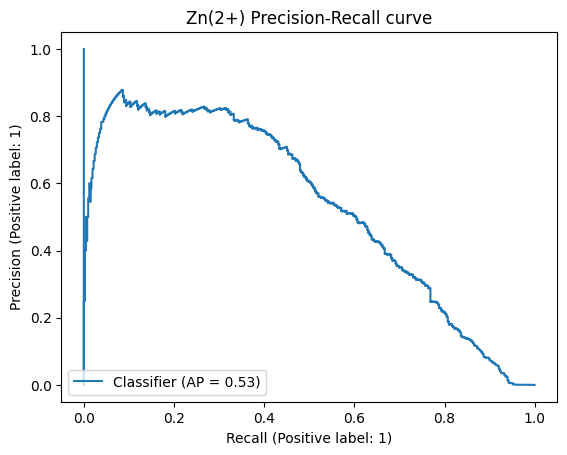

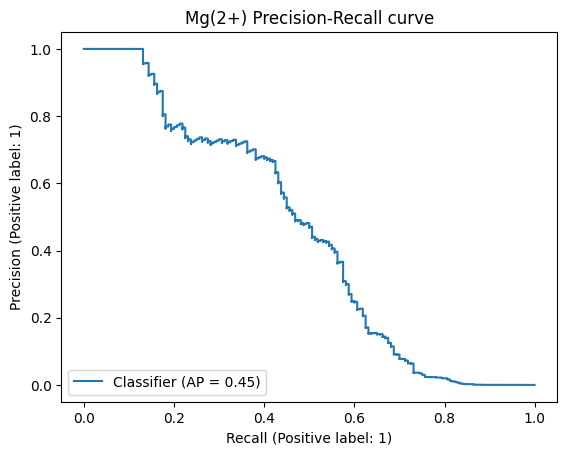

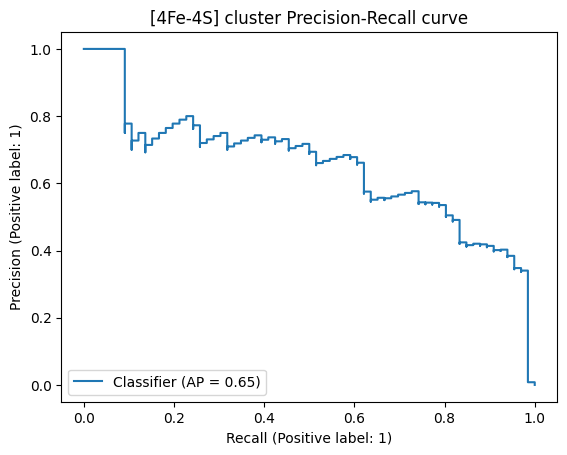

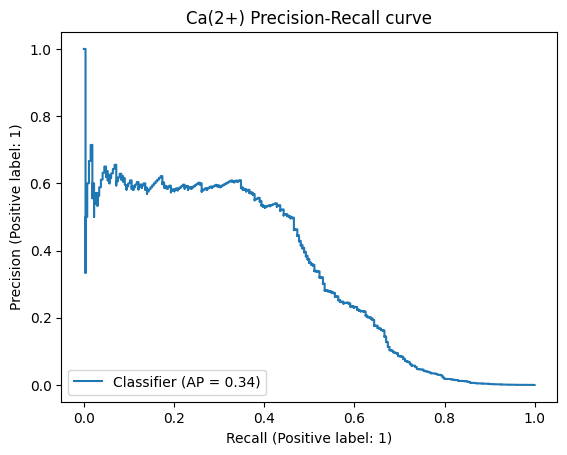

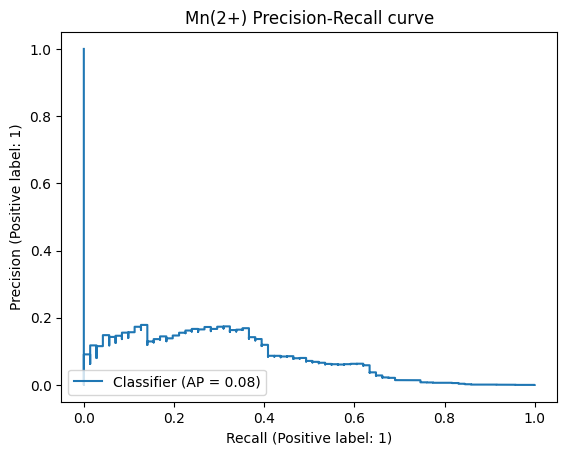

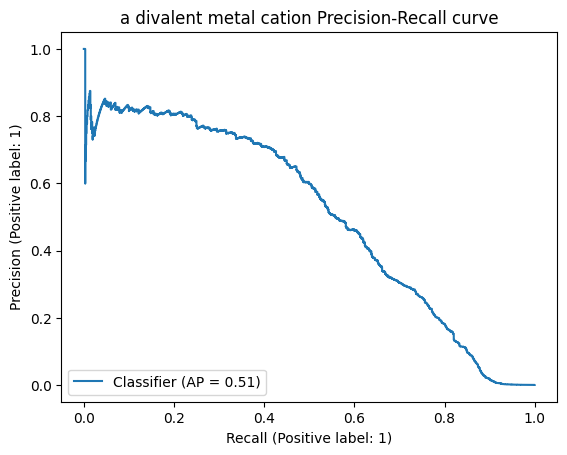

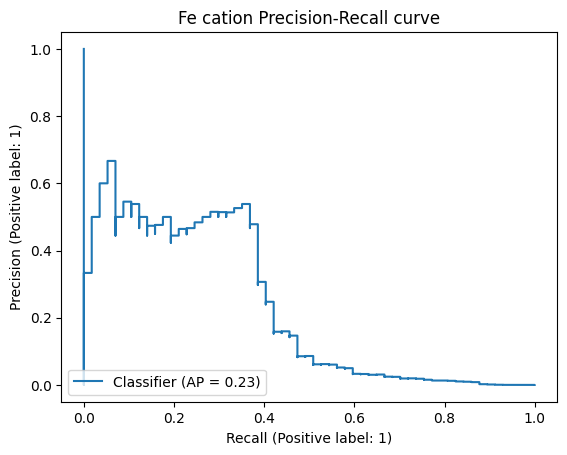

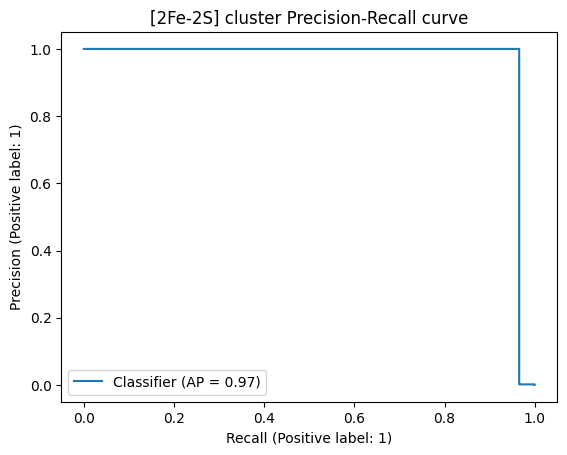

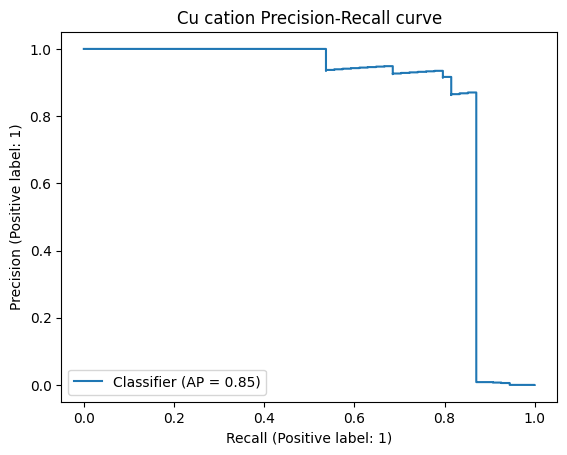

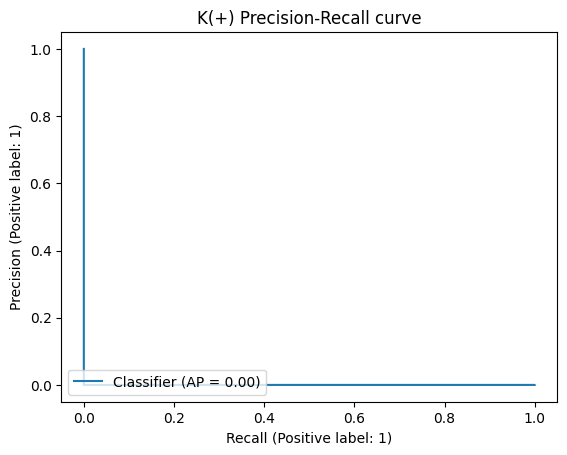

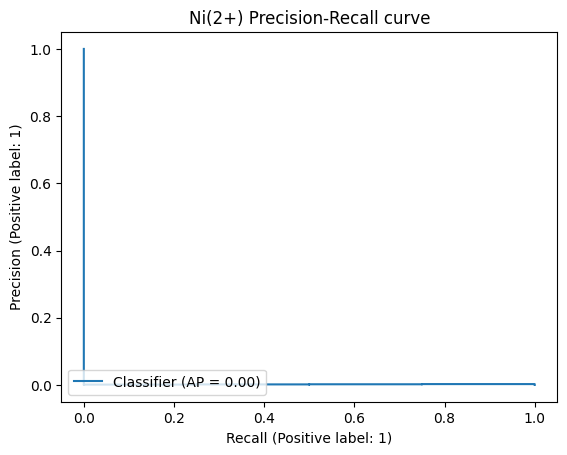

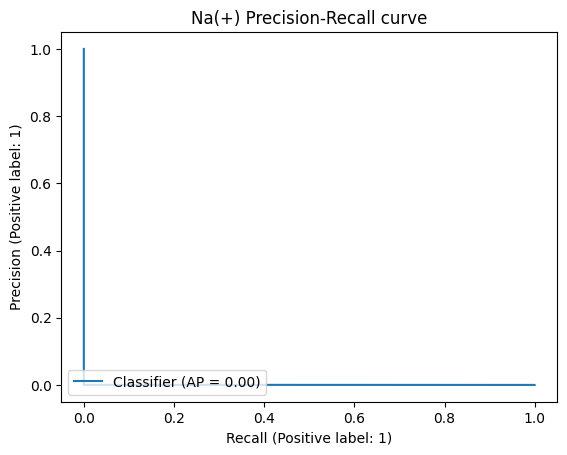

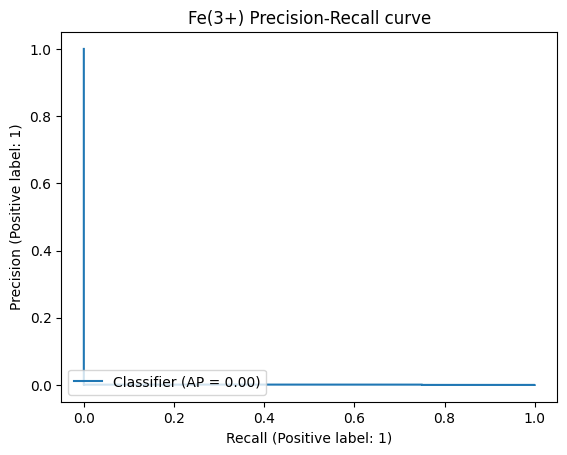

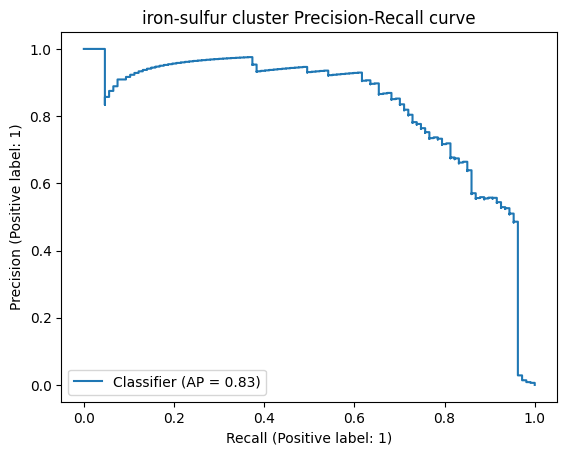

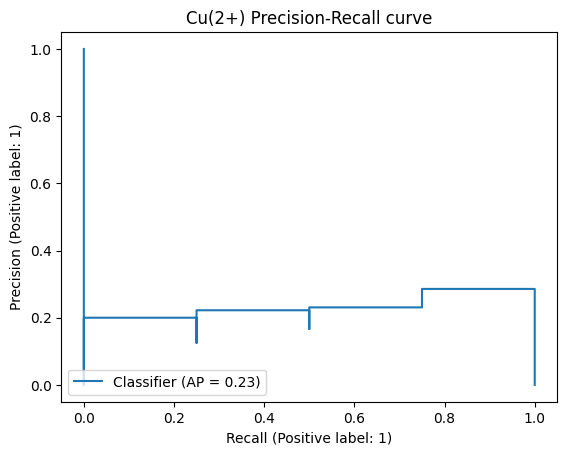

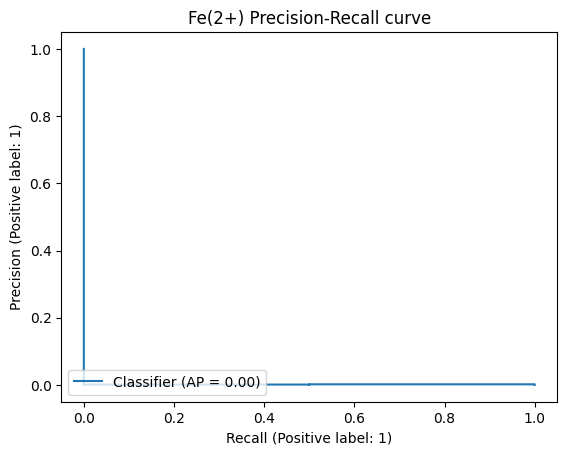

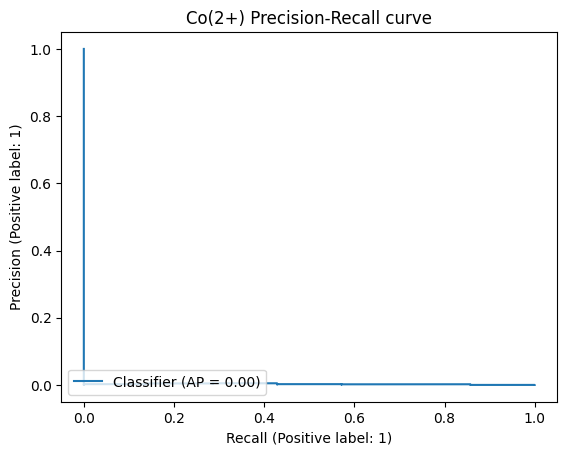

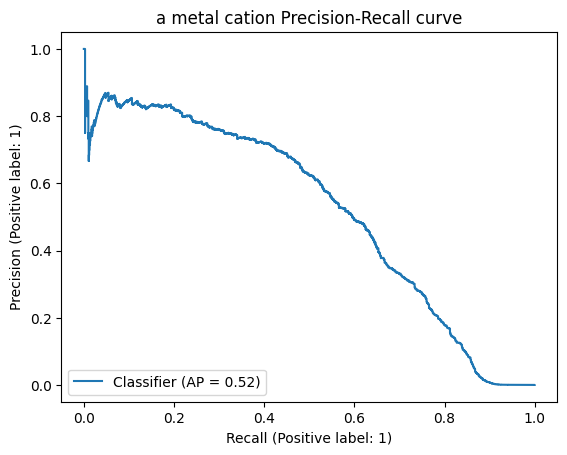

In [ ]:
# test (pass in the loader)
trainer.test(model=model, dataloaders=test_dataloader,
             ckpt_path=r'best')


### Threshold tuning

In [ ]:
model = model_gen.load_from_checkpoint(checkpoint_path=r"PATH", map_location=None)
model.thres_tune = True
# init trainer with whatever options
trainer = pl.Trainer(accelerator='gpu')
trainer.test(model=model, dataloaders=val_dataloader)
val_result = [model.y_true, model.y_pred]

In [ ]:
import os
output_path=r"OUTPUT_PATH"
dc = val_tool.mcc_sum(val_result[0], val_result[1], np.arange(0.1, 1, 0.01))
df = pd.DataFrame(dc)
df.to_csv(output_path, mode='a', header=not os.path.exists(output_path))